# CNN DQN, Deep Q Learning

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2grey
from skimage.transform import rescale

from collections import namedtuple, deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 32
GAMMA = 0.99
TAU = 1e-4 # for soft update of target parameters
LR = 2.5e-4
PRINT_EVERY = 500
UPDATE_EVERY = 4
NUM_FRAMES = 4

## Set Environment

In [7]:
ENV_NAME = 'BreakoutDeterministic-v4'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

In [8]:
print('Environment Display')
env.reset() # reset environment to a new, random state
env.render()

print('State space: {}'.format(env.observation_space))
print('Action space: {}'.format(env.action_space))

Environment Display
State space: Box(210, 160, 3)
Action space: Discrete(4)


## Build DQN Architecture

In [9]:
class DQN(nn.Module):
    """Define DQN architecture."""
    
    def __init__(self, num_frames, num_actions, seed):
        """Initialize parameters and build model."""
        
        super(DQN, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.conv1_layer = nn.Conv2d(in_channels=num_frames, out_channels=16, kernel_size=8, stride=4, padding=2)
        self.conv2_layer = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1)
        
        self.fc1_layer = nn.Linear(in_features=3200, out_features=256)
        self.fc2_layer = nn.Linear(in_features=256, out_features=num_actions)
        
    def flatten(self, x):
        batch_size = x.size()[0]
        x = x.view(batch_size, -1)
        return x
        
    def forward(self, state):
        """Build a network that maps state into action values."""
        
        x = F.relu(self.conv1_layer(state)) # input: (80, 80, 4), output: (20, 20, 16)
        x = F.relu(self.conv2_layer(x))     # input: (20, 20, 16), output: (10, 10, 32)
        x = self.flatten(x)                 # input: (10, 10, 32), output: (3200,)
        x = F.relu(self.fc1_layer(x))       # input: (3200,), output: (256,)
        Qsa = self.fc2_layer(x)             # input: (256,), output: (4,)
        
        return Qsa        

## Set Replay Buffer

In [10]:
class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayMemory object."""
        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to buffer."""
        
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float()
        states = states.to(device)
        
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long()
        actions = actions.to(device)
        
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float()
        rewards = rewards.to(device)
        
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float()
        next_states = next_states.to(device)
        
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float()
        dones = dones.to(device)
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define CNN DQN Agent

In [11]:
class CNN_DQNAgent():
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, num_frames, action_size, seed):
        """Initialize an agent object."""
        
        self.num_frames = num_frames
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.dqn_net = DQN(num_frames, action_size, seed).to(device)
        self.target_net = DQN(num_frames, action_size, seed).to(device)
        self.optimizer = optim.RMSprop(self.dqn_net.parameters(), lr=LR, alpha=0.95, eps=0.01)
        
        # Replay Buffer
        self.buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
        
    def memorize(self, state, action, reward, next_state, done):
        """Save experience in replay buffer."""
        
        self.buffer.add(state, action, reward, next_state, done)
    
        self.time_step = (self.time_step + 1) % UPDATE_EVERY
        if self.time_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, GAMMA)
                
    def preprocess(self, state):
        
        state = rgb2grey(state[35:195, :, :])
        state = rescale(state, scale=0.5)
        state = state[np.newaxis, np.newaxis, :, :]
        
        return state
    
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().to(device)
        
        self.dqn_net.eval()
        with torch.no_grad():
            action_values = self.dqn_net(state)
        self.dqn_net.train()
        
        # epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples."""
    
        states, actions, rewards, next_states, dones = experiences
        
        self.optimizer.zero_grad()
        
        # get index of maximum value for next state
        Qsa_next = self.dqn_net(next_states).detach()
        _, action_max = Qsa_next.max(1)

        # get max predicted Q values (for next states) from target network
        Q_target_next = self.target_net(next_states).detach().gather(1, action_max.unsqueeze(1))
        
        # compute Q target
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        
        # get expected Q values from dqn network
        Q_expected = self.dqn_net(states).gather(1, actions)
        
        # compute loss
        loss = F.mse_loss(Q_expected, Q_target)
        
        # minimize the loss
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.dqn_net, self.target_net, TAU)
        
    def soft_update(self, dqn_net, target_net, tau):
        """Soft update target network parameters."""
        
        for dqn_param, target_param in zip(dqn_net.parameters(), target_net.parameters()):
            target_param.data.copy_(tau*dqn_param.data + (1.0-tau) * target_param.data)
            
    def watch(self, num_episodes=3):
        
        num_episodes = num_episodes
        scores = []
        scores_window = deque(maxlen=500)    

        for i_episode in range(1, num_episodes+1):

            state = env.reset()
            state = agent.preprocess(state)

            done = False
            score = 0

            while not done:

                while state.shape[1] < NUM_FRAMES:
                    action = 1 # fire up

                    next_state, reward, done, _ = env.step(action)
                    next_state = agent.preprocess(next_state)

                    state = np.concatenate((state, next_state), axis=1)

                env.render() # render the screen
                action = agent.act(state) # select an action

                next_state, reward, done, _ = env.step(action)
                next_state, reward, done, _ = env.step(action)
                next_state = agent.preprocess(next_state)
                next_state = np.concatenate((state, next_state), axis=1)
                next_state = next_state[:, 1:, :, :]

                state = next_state
                score += reward
                if done:
                    break

            scores_window.append(score)
            scores.append(score)
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')

        env.close()

In [12]:
agent = CNN_DQNAgent(num_frames=NUM_FRAMES, action_size=env.action_space.n, seed=90)

In [13]:
# watch an untrained agent
agent.watch(num_episodes=3)

## Train The Agent

In [14]:
def train_agent(num_episodes, eps_start=1.0, eps_end=0.1, eps_decay=0.995):
    """Train DQN agent."""
    
    scores = []
    scores_window = deque(maxlen=500)
    eps = eps_start
    
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        state = agent.preprocess(state)
        
        done = False
        score = 0
        
        while not done:
            
            env.render()
            
            while state.shape[1] < NUM_FRAMES:
                action = 1 # fire up
                
                next_state, reward, done, _ = env.step(action)
                next_state = agent.preprocess(next_state)
                
                state = np.concatenate((state, next_state), axis=1)
            
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            next_state = agent.preprocess(next_state)
            next_state = np.concatenate((state, next_state), axis=1)
            next_state = next_state[:, 1:, :, :]

            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 60.0:
            print(f'\nEnvironment solved in {i_episode-500:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            if not os.path.exists('./agents/'): os.makedirs('./agents/')
            torch.save(agent.dqn_net.state_dict(), f'./agents/CNN_DQN_{ENV_NAME}.pth')
            
    print('Training completed.')
    return scores

In [15]:
scores = train_agent(num_episodes=int(5e4), eps_start=1.0, eps_end=0.1, eps_decay=0.995)

Episode: 500, Average Score: 4.00
Episode: 1000, Average Score: 3.64
Episode: 1500, Average Score: 3.01
Episode: 2000, Average Score: 2.75
Episode: 2500, Average Score: 2.92
Episode: 3000, Average Score: 2.63
Episode: 3500, Average Score: 4.04
Episode: 4000, Average Score: 3.63
Episode: 4500, Average Score: 4.96
Episode: 5000, Average Score: 3.22
Episode: 5500, Average Score: 3.07
Episode: 6000, Average Score: 6.55
Episode: 6500, Average Score: 6.61
Episode: 7000, Average Score: 4.72
Episode: 7500, Average Score: 3.85
Episode: 8000, Average Score: 4.10
Episode: 8500, Average Score: 4.32
Episode: 9000, Average Score: 5.00
Episode: 9500, Average Score: 6.25
Episode: 10000, Average Score: 6.57
Episode: 10500, Average Score: 6.07
Episode: 11000, Average Score: 5.58
Episode: 11500, Average Score: 6.03
Episode: 12000, Average Score: 5.75
Episode: 12500, Average Score: 6.26
Episode: 13000, Average Score: 6.15
Episode: 13500, Average Score: 5.98
Episode: 14000, Average Score: 5.96
Episode: 145

## Evaluate The Agent

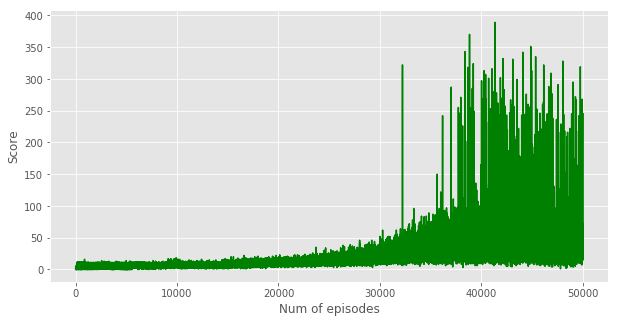

In [16]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_agent_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [17]:
# load the weights of smart agent
agent.dqn_net.load_state_dict(torch.load(f'./agents/CNN_DQN_{ENV_NAME}.pth'));

In [18]:
# watch the smart agent
agent.watch(num_episodes=3)

---